# [Projet 6: Catégorisez automatiquement des questions](https://openclassrooms.com/fr/projects/categorisez-automatiquement-des-questions)
(parcours data: [here](https://openclassrooms.com/paths/63-data-scientist))

## Data cleaning

Data exporter (StackExchange): [here](https://data.stackexchange.com/stackoverflow/query/new).  
My minimal SQL query:
```
SELECT
   Id,Body,Title,Tags
FROM
   Posts
WHERE
   Id > 800000 and Id < 1000000 and Body<>'' and Title<>'' and Tags <>''
```

Resources:
- [tutorial on kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words) (I did this basically on my own, but look at the features with scikit-learn section)

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(HOME+'Documents/GitHub/OCDataSciencePath/Project6/Work/')    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import pandas as pd
import time
from scipy.sparse import hstack
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

Some info and uses for [BeautifulSoup](https://pypi.org/project/beautifulsoup4/): [here](https://www.pythonforbeginners.com/beautifulsoup/beautifulsoup-4-python),

In [2]:
from bs4 import BeautifulSoup # conda install beautifulsoup4

Some info and uses for [NLTK](https://pypi.org/project/nltk/): [here](http://www.nltk.org/book/),

In [3]:
import nltk
#nltk.download('punkt')

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [5]:
from Pkg.helper import basicHTMLTextCleaner, basicTagTextCleaner, isValidData # needs correct working directory

### Data

In [6]:
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/Data/'    # @home
    pathToIntellDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/Intelligence/'    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))

In [7]:
# filename = 'QueryResults_10k.csv'
# df = pd.read_csv(pathToDataDir+filename,index_col='Id')

first = True
for i in range(1,8):
# for i in range(1,2):
    filename = 'QueryResults-{}.csv'.format(i)
    df_ = pd.read_csv(pathToDataDir+filename,index_col='Id')
    if first:
        df = df_.copy()
        first = False
    else:
        df = df.append(df_)

print(df.shape)

(174696, 3)


In [8]:
np.random.seed(8)

In [9]:
n,p = df.shape
k = .8
idx_train = np.random.choice((True,False),n,p=(k,1-k))
df_train,df_test = df.iloc[idx_train,:].copy(),df.iloc[~idx_train,:].copy()

In [10]:
print(df_train.shape,df_test.shape)
df_train.sample(5)

(140106, 3) (34590, 3)


,Body,Title,Tags
Id,,,
696573,<p>I have a function getSlope which takes as p...,Unexpected loss of precision when dividing dou...,<c++><double><precision>
46354,<p>I'm trying to perform a SQL query through a...,"""Invalid column name"" error on SQL statement f...",<sql><sql-server>
607250,<p>I have a generic type that is parameterized...,How do I get the type object of a genericized ...,<java><generics>
902017,<p>I saw a program(RAPGET) which downloads a f...,Data from web-page to a text box in application?,<vb6>
399538,<p>I'm building a C++ application and need to ...,How do I link PDCurses to a C++ application on...,<c++><windows><linker><ncurses><pdcurses>


### Basic text cleaning

In [11]:
def applyCleaner(df,tokenizer,stopwords,stemer):
    '''
    applies the cleaner to a pd.DataFrame. See called functions for help.
    '''
    for c in ('Body','Title'):
        df[c+'_clean'] = df[c].apply(lambda x: basicHTMLTextCleaner(x,tokenizer,stopwords,stemer))
    for c in ('Tags',):
        df[c+'_clean'] = df[c].apply(lambda x: basicTagTextCleaner(x))
        
    return df

In [12]:
# define the potential tokens (to be used with RegexpTokenizer(gaps=False))
rex = ''
rex += '\.?'          # token can start by a dot
rex += '[a-zA-Z]+'    # then a word in letters
rex += '[0-9#+]*'     # then potentially numbers or some symbols

In [13]:
stopwords = set(nltk.corpus.stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(rex,gaps=False)
stemer = nltk.PorterStemmer()

tic = time.time()
df_train = applyCleaner(df_train,tokenizer,stopwords,stemer)
df_test = applyCleaner(df_test,tokenizer,stopwords,stemer)
print('done: took {}s'.format(np.round(time.time()-tic,2)))

done: took 651.01s


In [14]:
# save transformers for later
pickle.dump(stopwords, open(pathToIntellDir+'stopwords.pkl','wb'))
pickle.dump(tokenizer, open(pathToIntellDir+'tokenizer.pkl','wb'))
pickle.dump(stemer, open(pathToIntellDir+'stemer.pkl','wb'))

In [15]:
df_train.sample(5)

,Body,Title,Tags,Body_clean,Title_clean,Tags_clean
Id,,,,,,
598041,<p>I have a stored procedure that returns a la...,Querying results of a stored procedure,<sql><stored-procedures><sybase>,store procedur return larg number result would...,queri result store procedur,<sql><stored-procedures><sybase>
791030,<p>Say my database tables have columns like <c...,Should I store Enum ID/values in the database ...,<c#><database><enums><constants>,say databas tabl column like usertyp salestyp ...,store enum id valu databas c# enumer,<c#><database><enums><constants>
577209,<p>I was creating a table in SQL Server CE and...,Why doesn't SQL Server CE support varchar?,<sql-server-ce>,creat tabl sql server ce realiz support varcha...,sql server ce support varchar,<sql-server-ce>
929495,<p>I'm using the Code::Blocks IDE with GCC/Min...,Why is MinGW very slow?,<c++><performance><mingw><codeblocks>,use code block ide gcc mingw window tri build ...,mingw slow,<c++><performance><mingw><codeblocks>
593905,<p>Could anybody help me to rename database in...,rename database in psql,<postgresql>,could anybodi help renam databas postgresql li...,renam databas psql,<postgresql>


### Vectorization

Resources
- [scikit tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) (also used in this [kaggle example](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words))

*Input texts:*

In [16]:
# count occurences (beware to fit the dictionary only on train data!)
# NB: deal with tags separately, as they basically need one-hot encoding
max_df = .3 # should be possible to push up to .1 given the low frequencies of the tags...
min_df = .01

V_body = 500 # 100 # 20 # 500
count_body = CountVectorizer(analyzer = 'word',   # entities to be counted
                             strip_accents = None,
                             preprocessor = None, # because we did it ourselves
                             lowercase = False,   # because we did it ourselves
                             stop_words = None,   # because we did it ourselves
                             tokenizer = None,    # because we did it ourselves
                             token_pattern = rex, # must rewrite the tokens!
                             max_df = max_df,     # perform additional stopword trimming 
                             min_df = min_df,     # drop too rare terms
                             max_features = V_body) 

count_body.fit(df_train['Body_clean'])

V_title = 100 # 20 # 5 # 100
count_title = CountVectorizer(analyzer = 'word',   # entities to be counted
                              strip_accents = None,
                              preprocessor = None, # because we did it ourselves
                              lowercase = False,   # because we did it ourselves
                              stop_words = None,   # because we did it ourselves
                              tokenizer = None,    # because we did it ourselves
                              token_pattern = rex, # must rewrite the tokens!
                              max_df = max_df,     # perform additional stopword trimming 
                              min_df = min_df,     # drop too rare terms
                              max_features = V_title) 

count_title.fit(df_train['Title_clean'])

# transform to vectors using the fitted dictionaries
body_train = count_body.transform(df_train['Body_clean'])
title_train = count_title.transform(df_train['Title_clean'])

body_test = count_body.transform(df_test['Body_clean'])
title_test = count_title.transform(df_test['Title_clean'])

In [17]:
print('\nvocab for body (length {}): {}'.format(len(count_body.vocabulary_),count_body.vocabulary_.keys()))
print('\nvocab for title (length {}): {}'.format(len(count_title.vocabulary_),count_title.vocabulary_.keys()))


vocab for body (length 500): dict_keys(['given', 'specif', 'valu', 'display', 'time', 'day', 'standard', 'way', 'web', 'server', 'abl', 'user', 'within', 'page', 'http', 'header', 'part', 'string', 'differ', '.net', 'queri', 'servic', 'return', 'type', 'via', 'public', 'static', 'db', 'new', 'execut', 'var', 'select', 'copi', 'work', 'get', 'result', 'set', 'store', 'data', 'mysql', 'look', 'person', 'defin', 'code', 'number', 'program', 'test', 'know', 'assembl', 'version', 'option', 'though', 'includ', 'specifi', 'main', 'x', 'e', 'f', 'n', 'doubl', 'int', 'case', 'catch', 'would', 'actual', 'start', 'stuff', 'system', 'build', 'script', 'configur', 'c', 'compil', 'bit', 'also', 'tri', 'order', 'around', 'still', 'come', 'top', 'everi', 'updat', 'tabl', 'throw', 'error', 'issu', 'api', 'c++', 'tell', 'miss', 'someth', 'relat', 'make', 'problem', 'much', 'idea', 'could', 'give', 'app', 'link', 'output', 'line', 'name', 'find', 'declar', 'fail', 'file', 'object', 'creat', 'check', 'ne

In [18]:
# use TF-IDF (beware to fit the IDF with train data!)
tfidf_body = TfidfTransformer(use_idf=True).fit(body_train)
tfidf_title = TfidfTransformer(use_idf=True).fit(title_train)

# transform using the fitted IDF
body2_train = tfidf_body.transform(body_train)
title2_train = tfidf_title.transform(title_train)

body2_test = tfidf_body.transform(body_test)
title2_test = tfidf_title.transform(title_test)

In [19]:
# save transformers for later use
pickle.dump(count_body, open(pathToIntellDir+'count_body.pkl','wb'))
pickle.dump(count_title, open(pathToIntellDir+'count_title.pkl','wb'))

pickle.dump(tfidf_body, open(pathToIntellDir+'tfidf_body.pkl','wb'))
pickle.dump(tfidf_title, open(pathToIntellDir+'tfidf_title.pkl','wb'))

In [20]:
body2_train[0,:]

<1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [21]:
title2_train[0,:]

<1x97 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

*Target tags:*

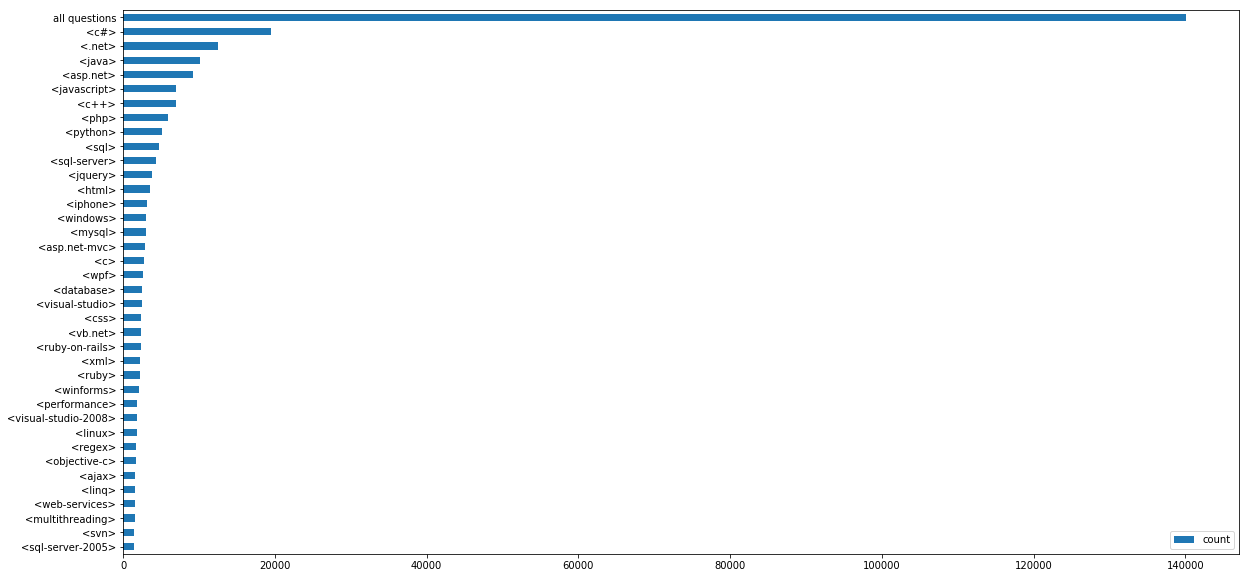

In [32]:
# analysis of the tags (NB: here we only 'multiplly'-one-hot encode: there is no need to compute TF-IDF!)

# count occurences
min_df_tag = .01 # we will only deal with not too rare tags

count_tag = CountVectorizer(analyzer = "word",   # entities to be counted
                            strip_accents = None,
                            preprocessor = None, # because we did it ourselves
                            lowercase = False,   # because we did it ourselves
                            stop_words = None,   # because we did it ourselves
                            tokenizer = None,    # because we did it ourselves
                            token_pattern = '<[^[<>]*>', # specific token for these tags
                            min_df = min_df_tag) 

count_tag.fit(df_train['Tags_clean'])

# transform
tag_train = count_tag.transform(df_train['Tags_clean'])
tag_test = count_tag.transform(df_test['Tags_clean'])

# plot number of questions per tag
tagCount = pd.DataFrame(index=['count'])
tagCount['all questions'] = tag_train.shape[0]
for t,i in count_tag.vocabulary_.items():
    tagCount[t] = tag_train[:,i].sum()
tagCount = tagCount.transpose()
tagCount = tagCount.sort_values(by='count',ascending=True)
tagCount.plot(kind='barh',figsize=(20,10))

In [33]:
print('\nvocab for tags (length {}): {}'.format(len(count_tag.vocabulary_),count_tag.vocabulary_.keys()))


vocab for tags (length 37): dict_keys(['<c#>', '<javascript>', '<html>', '<.net>', '<linq>', '<web-services>', '<mysql>', '<database>', '<performance>', '<c++>', '<c>', '<sql>', '<sql-server>', '<vb.net>', '<php>', '<ruby>', '<svn>', '<linux>', '<windows>', '<asp.net>', '<xml>', '<java>', '<sql-server-2005>', '<objective-c>', '<ruby-on-rails>', '<python>', '<winforms>', '<visual-studio>', '<css>', '<regex>', '<multithreading>', '<ajax>', '<wpf>', '<iphone>', '<asp.net-mvc>', '<visual-studio-2008>', '<jquery>'])


In [34]:
# save transofrmer for later use
pickle.dump(count_tag, open(pathToIntellDir+'count_tag.pkl','wb'))

In [35]:
tag_train[0,:].toarray()

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

*Merge together:*

In [36]:
x_train = hstack((body2_train,title2_train)) # need hstack because we work on sparse matrices...
x_test = hstack((body2_test,title2_test))

y_train = tag_train
y_test = tag_test

*Handle cases when some rows do not have selected words/tags...*

In [37]:
# SEE HOW TO AVOID THAT: go back to full matrices for subscripting, export...
x_train = x_train.toarray()
x_test = x_test.toarray()

y_train = y_train.toarray()
y_test = y_test.toarray()

In [38]:
isValid_train = isValidData(x_train,y_train,V_body)
isValid_test = isValidData(x_test,y_test,V_body)

print(np.array(isValid_train).mean())
print(np.array(isValid_test).mean())

x_train,y_train = x_train[isValid_train,:],y_train[isValid_train,:]
x_test,y_test = x_test[isValid_test,:],y_test[isValid_test,:]

0.641057485047
0.64885805146


In [39]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(89816, 597) (89816, 37)
(22444, 597) (22444, 37)


### Cleaned data

In [40]:
name,ext = os.path.splitext(filename)

#c = ('Body_clean','Title_clean','Tags_clean')
#df.loc[:,c].to_csv(os.path.join(pathToDataDir,name+'_clean'+ext),index=True)

np.savez(os.path.join(pathToDataDir,name+'_forLearning'), *[x_train,
                                                            x_test,
                                                            y_train,
                                                            y_test])